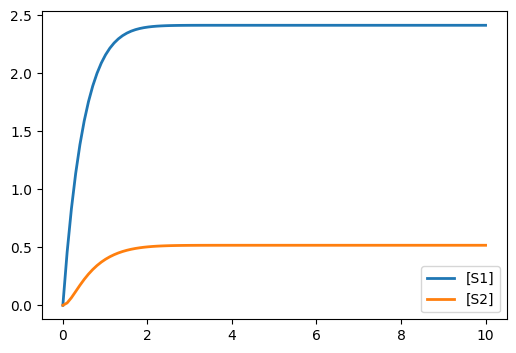

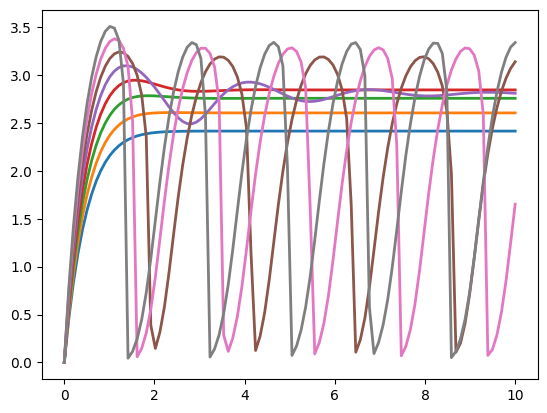

In [20]:
import tellurium as te
import numpy as np


model_str = """

-> S1; v0

S1 -> ; k2*S1

S1 -> S2; k4*S1*(1+k3*S2^4)

S2 -> ; k5*S2

v0 = 5;
k2 = 1;
k3 = 1;
k4 = 1;
k5 = 5;

"""


r = te.loada(model_str)


result = r.simulate(0, 10, 100)  


r.plot()


vo = np.arange(5, 9, 0.5)
for value in vo:
    r.v0 = value
    r.reset() #Resets to point of creation in the model, undefined parameters reset to 0
    m = r.simulate(0, 10, 100, ['time', 'S1'])
    te.plotArray(m, show = False, label = "vo = " + str(value), resetColorCycle = False)


as you increase v0 it starts to oscillate until you get to the threshold where it starts to oscilate. going through two transitions that starts off stable with no oscilations, at 7 there is a wiggle, past 7 full on oscilattions and at 8 it starts. there is a window in vo where it oscilate 

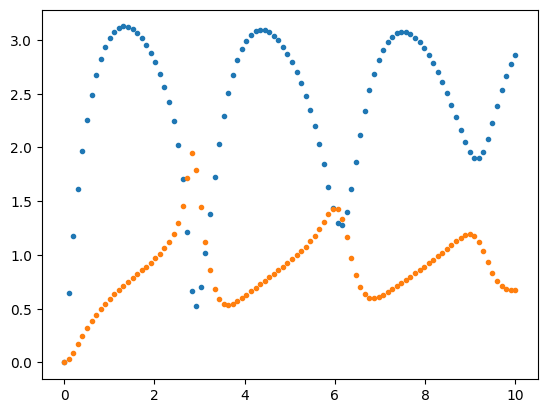

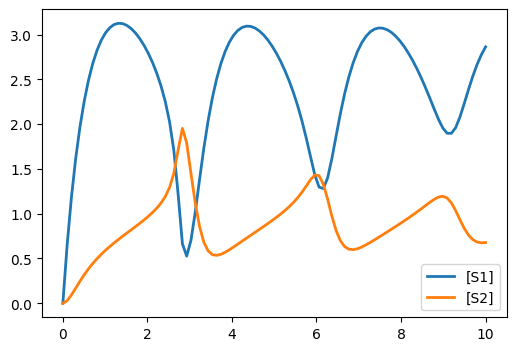

In [22]:
import matplotlib.pyplot as plt

model_str = """

-> S1; v0

S1 -> ; k2*S1

S1 -> S2; k4*S1*(1+k3*S2^4)

S2 -> ; k5*S2

v0 = 7.1;
k2 = 1;
k3 = 1;
k4 = 1;
k5 = 5;

"""


r = te.loada(model_str)


result = r.simulate(0, 10, 100)  



plt.plot(result[:,0], result[:, 1], '.')
plt.plot(result[:,0], result[:, 2], '.')
r.plot()

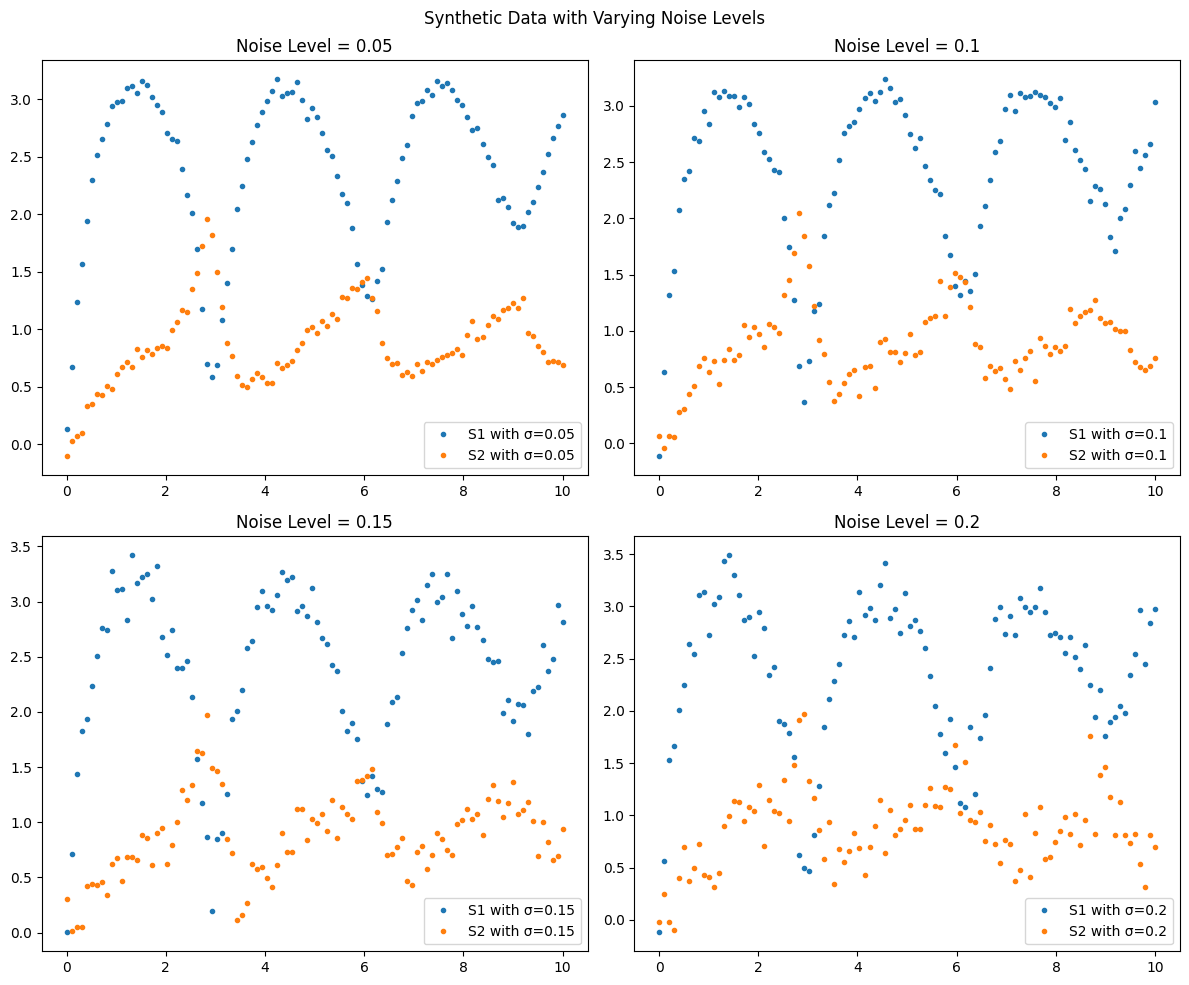

In [23]:
import numpy as np
import matplotlib.pyplot as plt


model_str = """
-> S1; v0
S1 -> ; k2*S1
S1 -> S2; k4*S1*(1+k3*S2^4)
S2 -> ; k5*S2
v0 = 7.1;
k2 = 1;
k3 = 1;
k4 = 1;
k5 = 5;
"""

# Load the model
r = te.loada(model_str)

# Simulate the model without noise
result = r.simulate(0, 10, 100)

# Define a range of noise levels
noise_levels = [0.05, 0.1, 0.15, 0.2]

# Create a 2x2 grid for plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Synthetic Data with Varying Noise Levels")

for i, noise_level in enumerate(noise_levels):
    # Generate synthetic data with noise
    noisy_data = result[:, 1:3] + noise_level * np.random.normal(size=(result.shape[0], 2))

    # Plot the data on the corresponding subplot
    ax = axes[i // 2, i % 2]
    ax.plot(result[:, 0], noisy_data[:, 0], '.', label=f'S1 with σ={noise_level}')
    ax.plot(result[:, 0], noisy_data[:, 1], '.', label=f'S2 with σ={noise_level}')
    ax.set_title(f"Noise Level = {noise_level}")
    ax.legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


In [ ]:
#experimentaldata > noise data already made
#simluateddata > any sim data 
#in residuals functions 

#A1 = experimentaldata[:,1] - simulateddata[:,1]
#A2 = experiemnetaldata[:,2] - simulateddata[:,2]
#A3 = np.vstack((A1, A2)) - to be the merged data 

In [53]:
%pip install lmfit

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


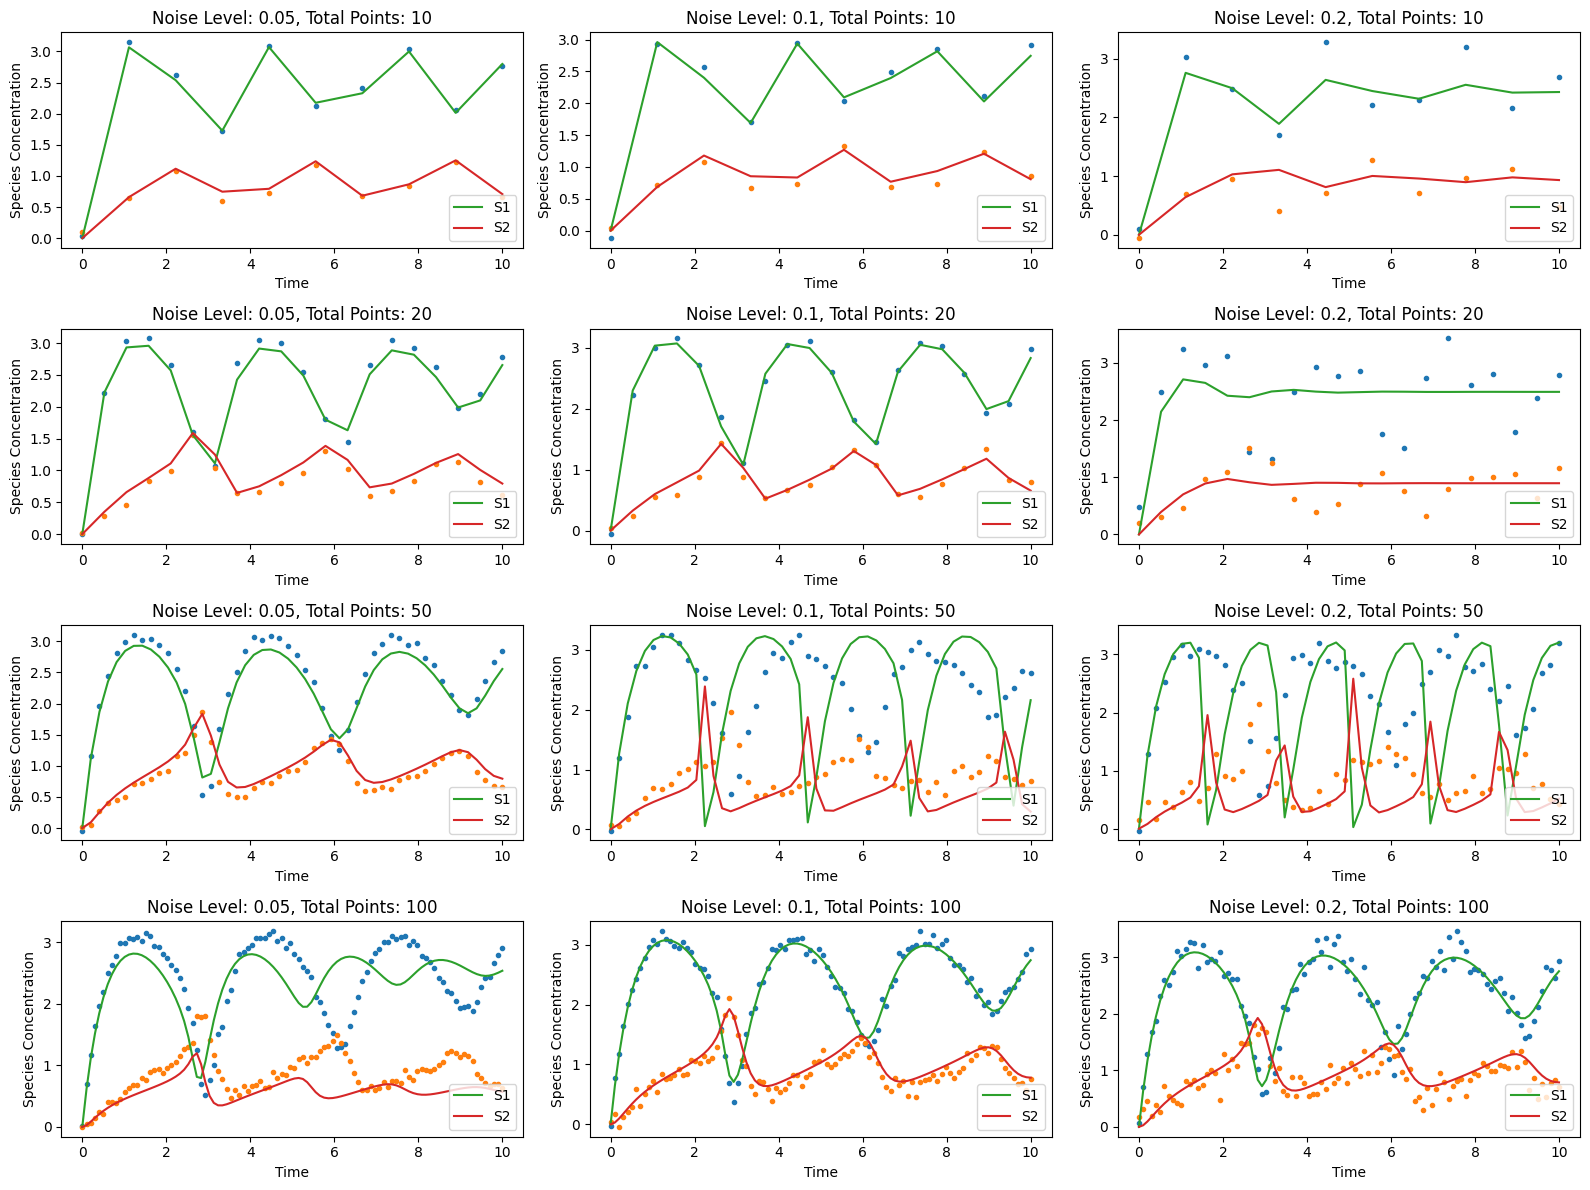

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import lmfit
import copy

# Define the model
model_str = """
-> S1; v0
S1 -> ; k2*S1
S1 -> S2; k4*S1*(1+k3*S2^4)
S2 -> ; k5*S2
v0 = 7.1;
k2 = 1;
k3 = 1;
k4 = 1;
k5 = 5;
"""

# Load the model
r = te.loada(model_str)

fig, axes = plt.subplots(4, 3, figsize=(16, 12))
noise_levels = [0.05, 0.1, 0.2]
n_data_points = [10, 20, 50, 100]
simulate_time = 10

for i in range(len(n_data_points)):
    for j in range(len(noise_levels)):
        r.reset()
        r = te.loada(model_str)
        data = r.simulate(0, simulate_time, n_data_points[i], ['S1', 'S2'])
        exp_data = copy.deepcopy(data)
        r.reset()
        data = r.simulate(0, simulate_time, n_data_points[i], ['time'])
        r.reset()
        exp_data[:, 0] = exp_data[:, 0] + np.random.normal(0, noise_levels[j], n_data_points[i])
        exp_data[:, 1] = exp_data[:, 1] + np.random.normal(0, noise_levels[j], n_data_points[i])

        parameters = lmfit.Parameters()
        parameters.add('v0', value=1, min=0, max=10)
        parameters.add('k3', value=1, min=0, max=10)
        parameters.add('k4', value=1, min=0, max=10)
        parameters.add('k5', value=1, min=0, max=10)

        def residuals2(p):
            r.reset()
            r.v0 = p['v0'].value
            r.k3 = p['k3'].value
            r.k4 = p['k4'].value
            r.k5 = p['k5'].value
            data = r.simulate(0, simulate_time, n_data_points[i], ['S1', 'S2'])
            A1 = exp_data[:, 0] - data[:, 0]
            A2 = exp_data[:, 1] - data[:, 1]
            A3 = np.hstack((A1, A2))
            return A3

        fitter = lmfit.Minimizer(residuals2, parameters)
        result = fitter.minimize(method='leastsq')

        ax = axes[i, j]
        ax.plot(data[:, 0], exp_data[:, 0], '.')
        ax.plot(data[:, 0], exp_data[:, 1], '.')
        ax.set_title(f'Noise Level: {noise_levels[j]}, Total Points: {n_data_points[i]}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Species Concentration')

        r.v0 = result.params['v0'].valu
        r.k3 = result.params['k3'].value
        r.k4 = result.params['k4'].value
        r.k5 = result.params['k5'].value
        r.reset()
        data = r.simulate(0, simulate_time, n_data_points[i], ['time', 'S1', 'S2'])

        ax.plot(data[:, 0], data[:, 1], label='S1')
        ax.plot(data[:, 0], data[:, 2], label='S2')
        ax.legend(loc="lower right")

# Adjust subplot spacing
plt.tight_layout()
plt.show()
